In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2024-06-12 00:18:25.097728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 00:18:25.097831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 00:18:25.229030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Generate data paths with labels
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')
            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')
                
                
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

filepaths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

In [4]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [5]:

batch_size = 64
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test data, use ImageDataGenerator without augmentation
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator() 

In [6]:
# Create the data generators
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


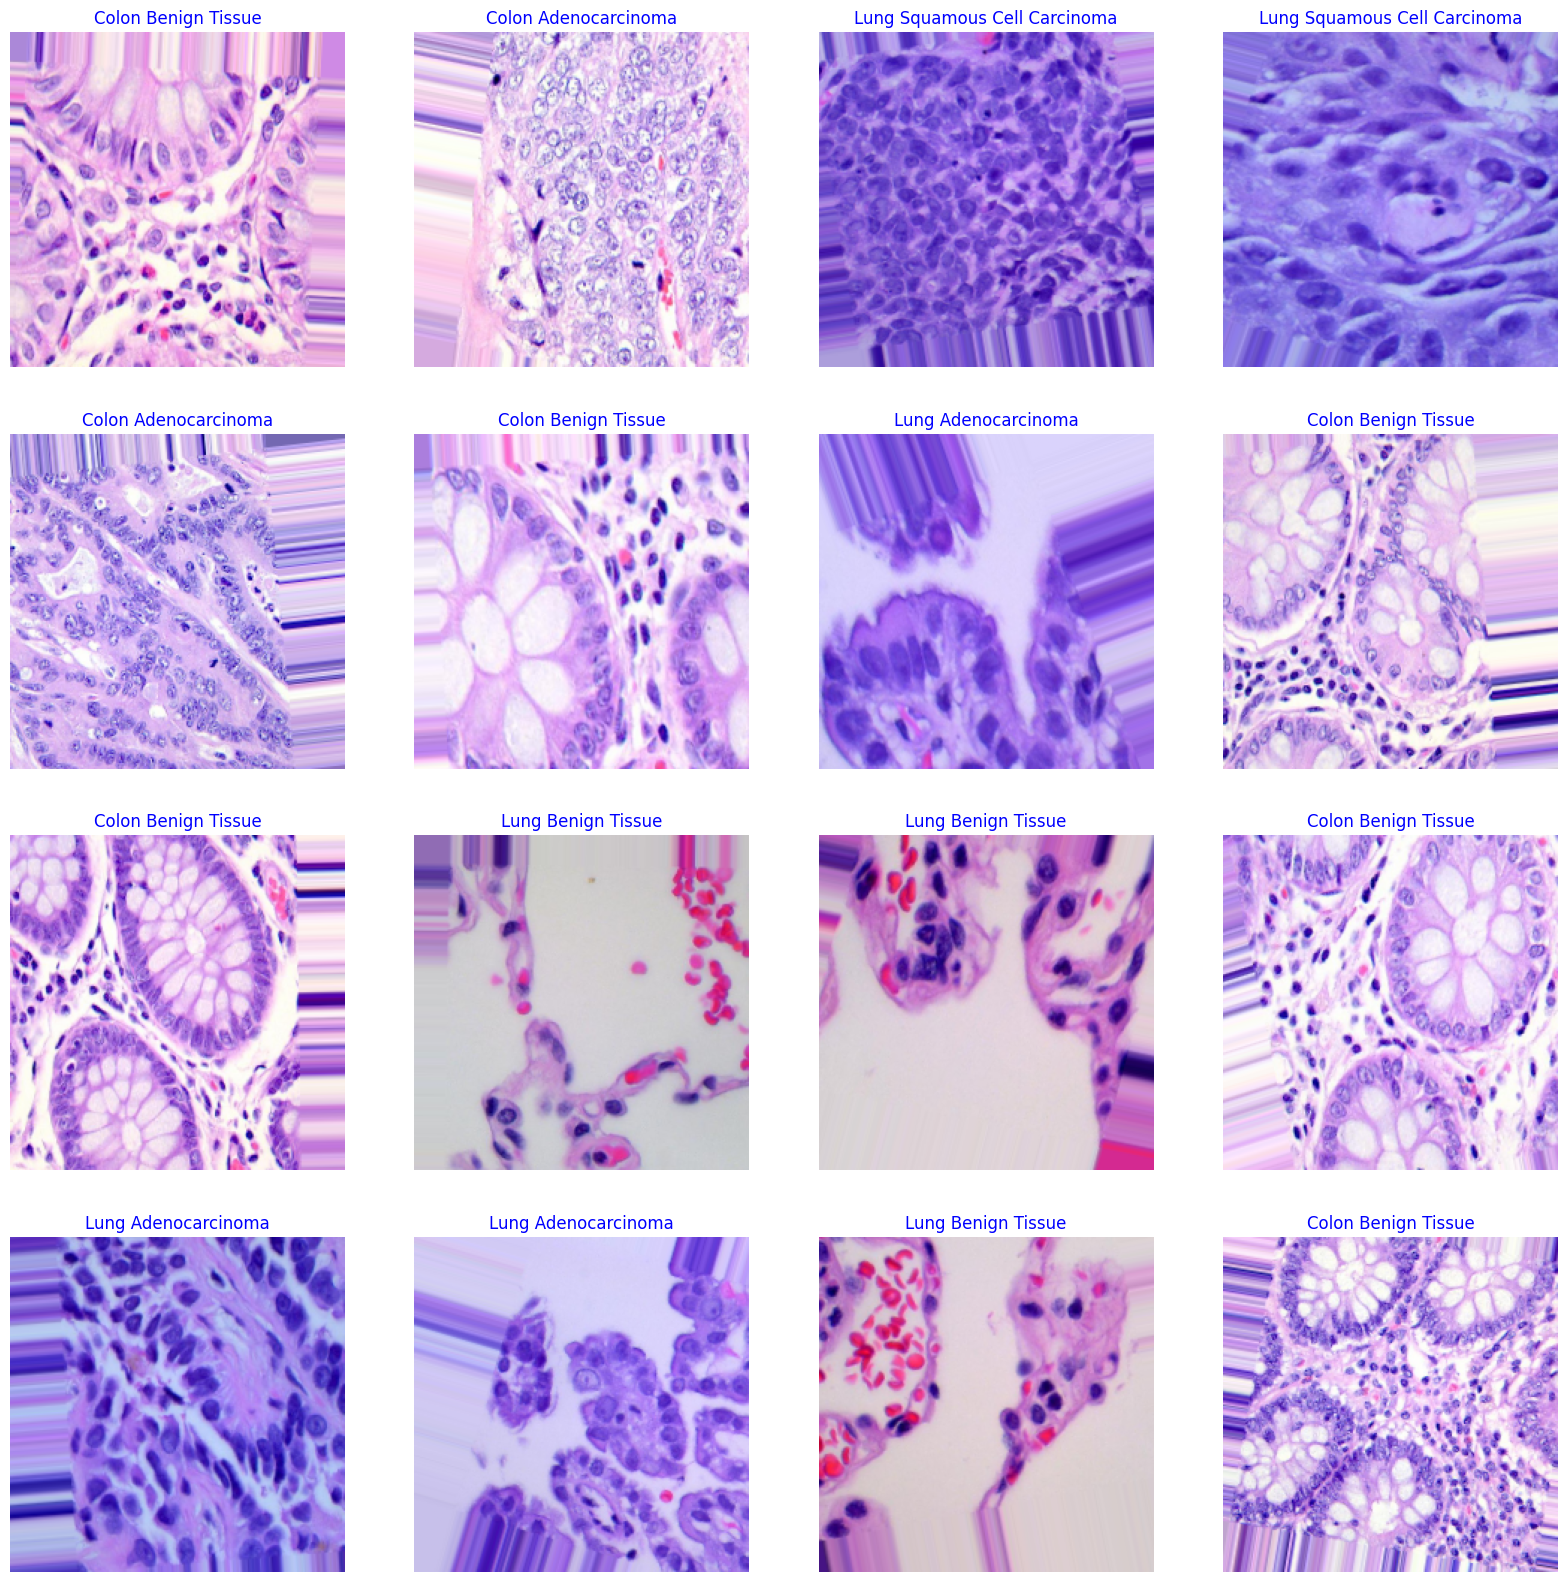

In [7]:
classes = list(train_gen.class_indices.keys())


# Visualize some augmented images
images, labels = next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(16):
    image = images[i]
    # Ensure the image is in the correct range [0, 1]
    image = image.astype(np.float32) / 255.0
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index] if classes else str(index)
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

from tensorflow import keras
from tensorflow.keras.regularizers import l2
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [224,224,3], padding='same'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(5, activation ='softmax')])

# .....................................................................................................................................................................................................

# from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization, Dropout, Flatten, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adamax

# model = Sequential([
#     Conv2D(16, (3, 3), activation='relu', input_shape=[224,224, 3], padding='same', kernel_regularizer=l2(0.001)),
#     MaxPooling2D(),
    
#     Conv2D(32, (2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
#     MaxPooling2D(),
    
#     SeparableConv2D(64, 3, activation='relu', padding='same', activity_regularizer=regularizers.l2(0.001)),
#     SeparableConv2D(64, 3, activation='relu', padding='same', activity_regularizer=regularizers.l2(0.001)),
#     BatchNormalization(),
#     MaxPooling2D(),
    
#     SeparableConv2D(128, 3, activation='relu', padding='same',),
#     SeparableConv2D(128, 3, activation='relu', padding='same',),
#     BatchNormalization(),
#     MaxPooling2D(),
#     Dropout(0.3),
    
#     SeparableConv2D(256, 3, activation='relu', padding='same',),
#     SeparableConv2D(256, 3, activation='relu', padding='same',),
#     BatchNormalization(),
#     MaxPooling2D(),
#     Dropout(0.3),
    
#     Flatten(),
    
#     Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.5),
    
#     Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.5),
    
#     Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.5),
    
#     Dense(5, activation='softmax')
# ])

# model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])




# .....................................................................................................................................................................................................
# model = keras.models.Sequential([
# keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [760,760,3], padding='same'),
# keras.layers.MaxPooling2D(),
# keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
# keras.layers.MaxPooling2D(),

# keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
# keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
# keras.layers.BatchNormalization(),
# keras.layers.MaxPool2D(),

# keras.layers.Dropout(0.6),

# keras.layers.Flatten(),

# keras.layers.Dense(512, activation='relu'),
# keras.layers.BatchNormalization(),
# keras.layers.Dropout(0.7),

# keras.layers.Dense(128, activation='relu'),
# keras.layers.BatchNormalization(),
# keras.layers.Dropout(0.5),

# keras.layers.Dense(64, activation='relu'),
# keras.layers.BatchNormalization(),
# keras.layers.Dropout(0.3),

# keras.layers.Dense(5, activation ='softmax')])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 56, 56, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 56, 56, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 28, 28, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 28, 28, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 14, 14, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 14, 14, 256)    │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,640,389 (25.33 MB)

 Trainable params: 6,638,085 (25.32 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [10]:
epochs = 100   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/100


2024-06-12 00:21:23.150851: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.57512, expected 3.11457
2024-06-12 00:21:23.150913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 3.34153, expected 2.88098
2024-06-12 00:21:23.151274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.69283, expected 3.82932
2024-06-12 00:21:23.151310: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 6.5873, expected 5.72379
2024-06-12 00:21:23.151324: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 7.24861, expected 6.3851
2024-06-12 00:21:23.151343: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.89519, expected 6.03168
2024-06-12 00:21:23.151356: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.97061, expected 5.1071
2024-06-12 00:21:23.151367: E exter

  2/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.2344 - loss: 2.2928   

I0000 00:00:1718151696.599479     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718151696.629649     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5971 - loss: 1.0293

2024-06-12 00:28:04.937423: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.30379, expected 1.97036
2024-06-12 00:28:04.937779: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.16142, expected 3.52349
2024-06-12 00:28:04.937839: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 4.95921, expected 4.32127
2024-06-12 00:28:04.937862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.2054, expected 4.56746
2024-06-12 00:28:04.937886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.92011, expected 4.28217
2024-06-12 00:28:04.937906: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.34126, expected 4.70333
2024-06-12 00:28:04.937918: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50183: 4.30751, expected 3.66957
2024-06-12 00:28:04.937929: E 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5975 - loss: 1.0284

W0000 00:00:1718152098.278229     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-12 00:28:41.706378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.91724, expected 3.41098
2024-06-12 00:28:41.706430: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.98621, expected 3.47995
2024-06-12 00:28:41.706440: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84: 4.03461, expected 3.52836
2024-06-12 00:28:41.706448: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 3.56278, expected 3.05652
2024-06-12 00:28:41.706456: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198: 3.61019, expected 3.10393
2024-06-12 00:28:41.706464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.49794, expected 1.99169
2024-06-12 00:28:41.706518: E external/local_xla/xla/ser

313/313 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.5978 - loss: 1.0275 - val_accuracy: 0.2000 - val_loss: 3.8339
Epoch 2/100


W0000 00:00:1718152122.866503     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 290s 926ms/step - accuracy: 0.8311 - loss: 0.4424 - val_accuracy: 0.2000 - val_loss: 5.6535
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 295s 941ms/step - accuracy: 0.8908 - loss: 0.2981 - val_accuracy: 0.8612 - val_loss: 0.3785
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 290s 927ms/step - accuracy: 0.9164 - loss: 0.2363 - val_accuracy: 0.8484 - val_loss: 0.3391
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 293s 937ms/step - accuracy: 0.9297 - loss: 0.1967 - val_accuracy: 0.8268 - val_loss: 0.5793
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 291s 930ms/step - accuracy: 0.9395 - loss: 0.1676 - val_accuracy: 0.8872 - val_loss: 0.3550
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 295s 942ms/step - accuracy: 0.9505 - loss: 0.1392 - val_accuracy: 0.9360 - val_loss: 0.1532
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 290s 927ms/step - accuracy: 0.9472 - loss: 0.1457 - val_accuracy: 0.9140 - val_loss: 0.2383
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 292s 934ms/step - accuracy: 0.9542 - los

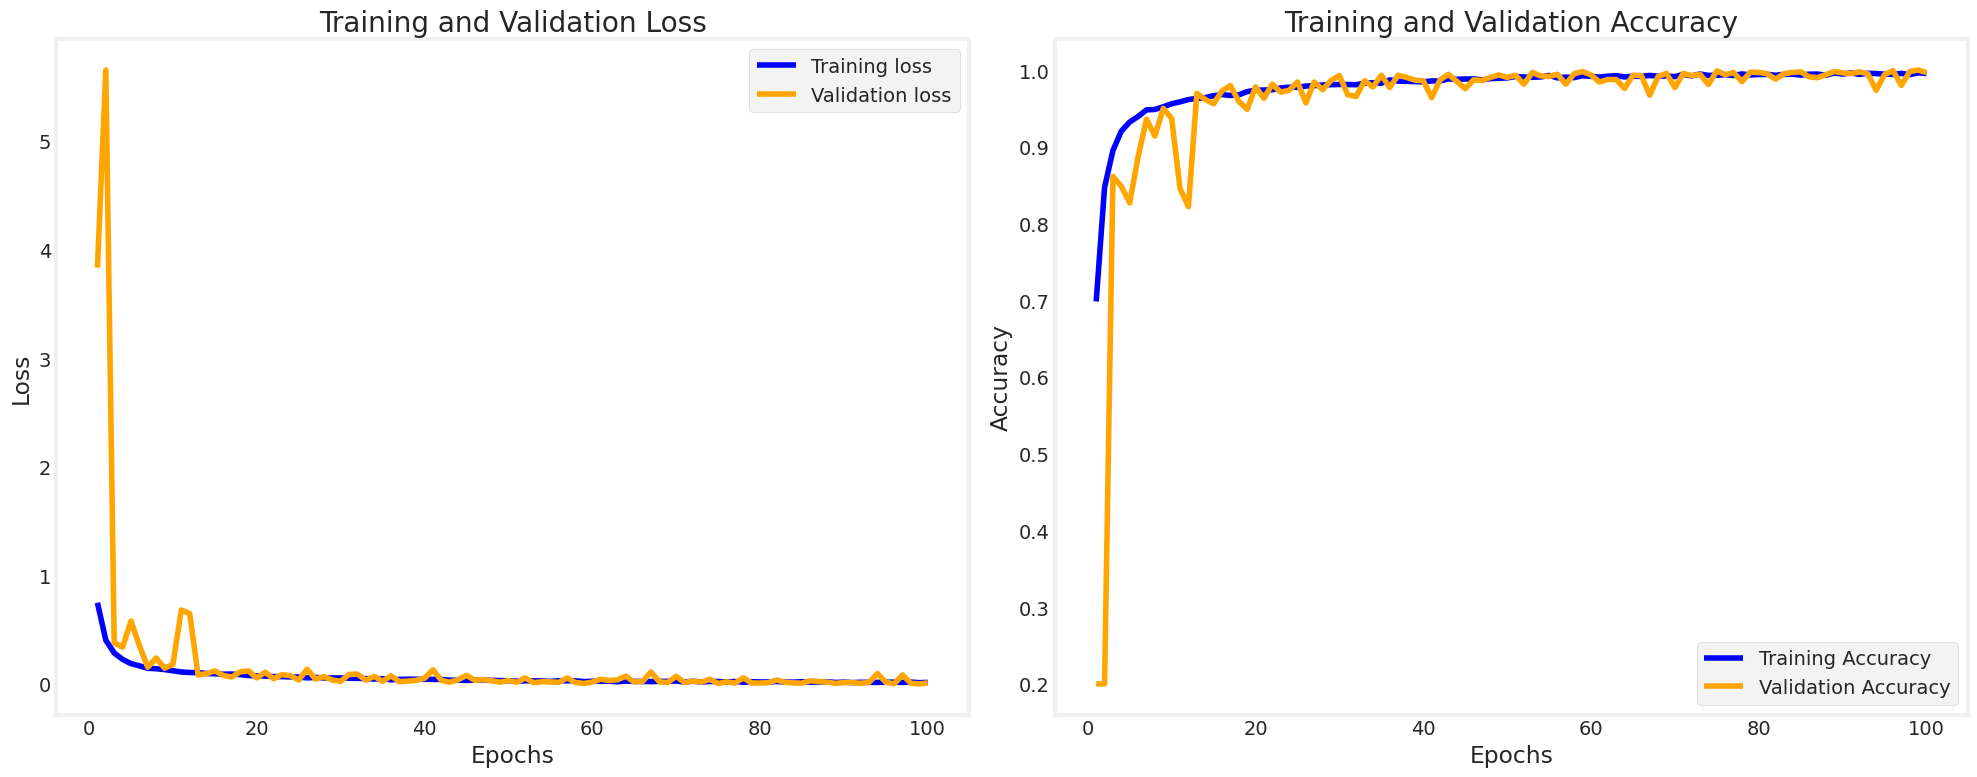

In [52]:
plt.figure(figsize=(20, 8), facecolor='white') 
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'b', label='Training loss') 
plt.plot(Epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False) 
plt.gca().set_facecolor('white')  

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'b', label='Training Accuracy') 
plt.plot(Epochs, val_acc, 'orange', label='Validation Accuracy')  
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False) 
plt.gca().set_facecolor('white') 

plt.tight_layout()
plt.show()


In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model on train, validation, and test data
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print the scores
print("Train Loss: ", train_score[0])
print("Train Accuracy: {:.2f}%".format(train_score[1] * 100))
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: {:.2f}%".format(valid_score[1] * 100))
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: {:.2f}%".format(test_score[1] * 100))


50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 905ms/step - accuracy: 0.9913 - loss: 0.0309
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.9972 - loss: 0.0091
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.9953 - loss: 0.0109
Train Loss:  0.023477910086512566
Train Accuracy: 99.25%
--------------------
Valid Loss:  0.00809260830283165
Valid Accuracy: 99.76%
--------------------
Test Loss:  0.009350314736366272
Test Accuracy: 99.68%


In [16]:

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 1/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step

W0000 00:00:1718181485.455866     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step


W0000 00:00:1718181497.664788     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


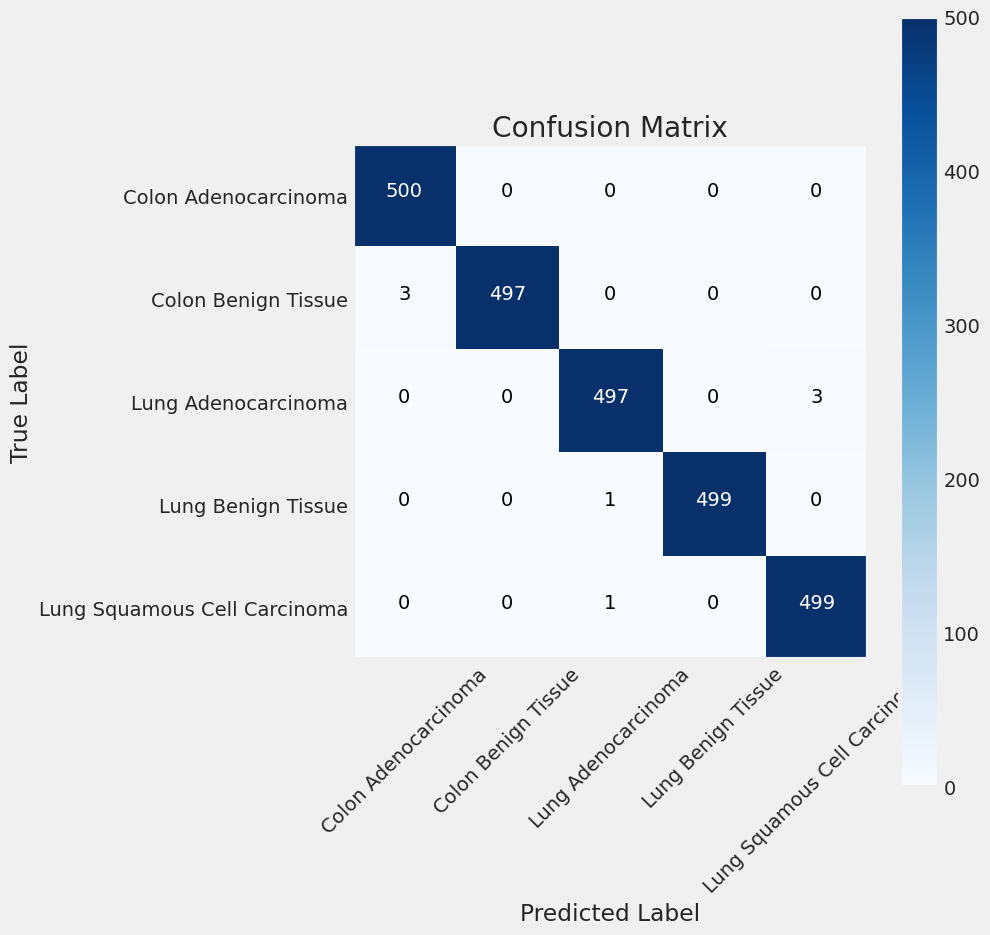

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)
plt.show()





In [18]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.99      1.00      1.00       500
         Colon Benign Tissue       1.00      0.99      1.00       500
         Lung Adenocarcinoma       1.00      0.99      0.99       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.99      1.00      1.00       500

                    accuracy                           1.00      2500
                   macro avg       1.00      1.00      1.00      2500
                weighted avg       1.00      1.00      1.00      2500



In [19]:
#Save the model
model.save('Model1_kera.h5')

In [20]:
tf.keras.models.save_model(model,'modeldep_acc99.hdf5')
model.save('model1_acc99_tf.h5') 
model.save('model12_acc99_kera.h5')
# Save the entire model (architecture and weights)
import joblib

# Assuming 'model' is your trained model
joblib.dump(model, 'model_acc99.pkl')


['model_acc99.pkl']

In [22]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Model1_kera.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [24]:
image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

2024-06-12 08:42:08.682017: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.85654, expected 2.92659
2024-06-12 08:42:08.682082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.2966, expected 5.36665
2024-06-12 08:42:08.682097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 5.15789, expected 4.22794
2024-06-12 08:42:08.682110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 5.45824, expected 4.52829
2024-06-12 08:42:08.682122: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 5.63214, expected 4.70219
2024-06-12 08:42:08.682132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 5.33488, expected 4.40493
2024-06-12 08:42:08.682141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.6038, expected 4.67384
2024-06-12 08:42:08.68

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Lung Adenocarcinoma


True Positives (TP): 2492
True Negatives (TN): 9992
False Positives (FP): 8
False Negatives (FN): 8


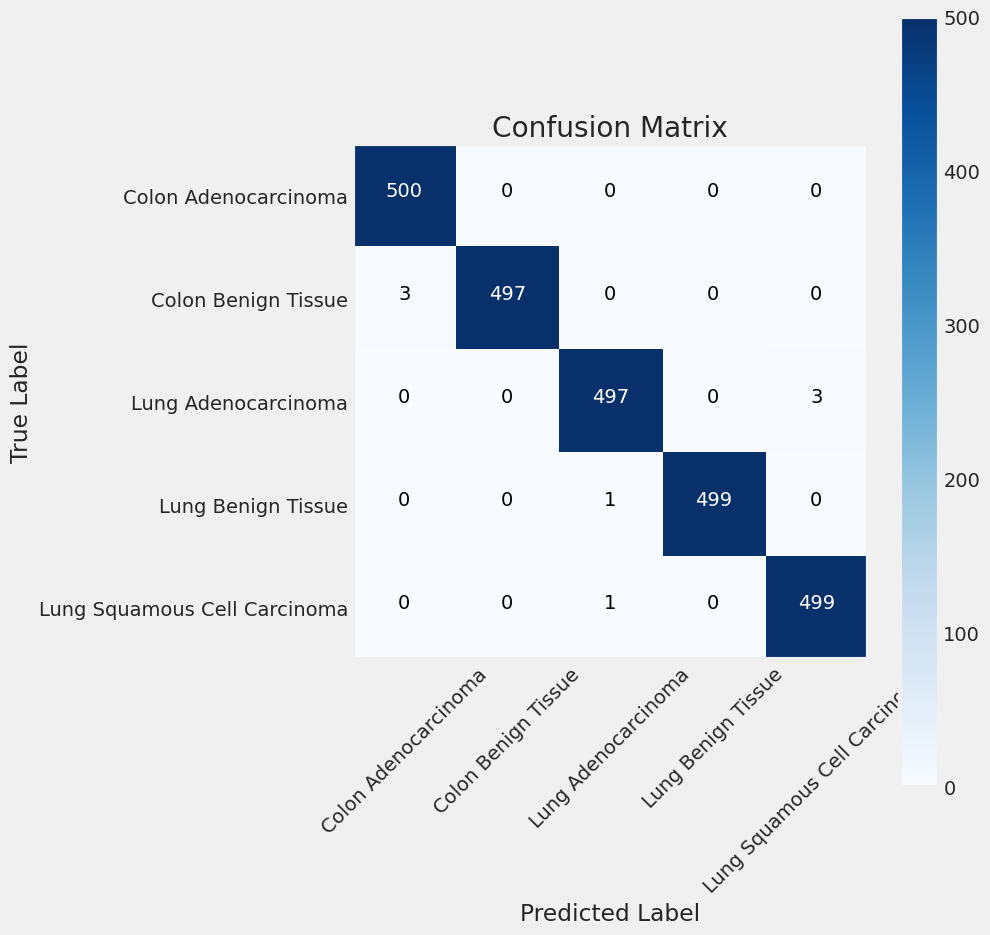

Class names: ['Colon Adenocarcinoma', 'Colon Benign Tissue', 'Lung Adenocarcinoma', 'Lung Benign Tissue', 'Lung Squamous Cell Carcinoma']
                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.99      1.00      1.00       500
         Colon Benign Tissue       1.00      0.99      1.00       500
         Lung Adenocarcinoma       1.00      0.99      0.99       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.99      1.00      1.00       500

                    accuracy                           1.00      2500
                   macro avg       1.00      1.00      1.00      2500
                weighted avg       1.00      1.00      1.00      2500



In [32]:

# Calculate and print confusion matrix metrics
def get_confusion_matrix_elements(cm):
    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)
    return true_positives, true_negatives, false_positives, false_negatives

# Get confusion matrix and calculate elements
cm = confusion_matrix(test_gen.classes, y_pred)
tp, tn, fp, fn = get_confusion_matrix_elements(cm)

# Print confusion matrix metrics
print(f"True Positives (TP): {np.sum(tp)}")
print(f"True Negatives (TN): {np.sum(tn)}")
print(f"False Positives (FP): {np.sum(fp)}")
print(f"False Negatives (FN): {np.sum(fn)}")

# Print confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)
plt.show()
# Verify class names
print("Class names:", classes)

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))


Class: Colon Adenocarcinoma
  True Positives (TP): 500
  True Negatives (TN): 1997
  False Positives (FP): 3
  False Negatives (FN): 0
--------------------
Class: Colon Benign Tissue
  True Positives (TP): 497
  True Negatives (TN): 2000
  False Positives (FP): 0
  False Negatives (FN): 3
--------------------
Class: Lung Adenocarcinoma
  True Positives (TP): 497
  True Negatives (TN): 1998
  False Positives (FP): 2
  False Negatives (FN): 3
--------------------
Class: Lung Benign Tissue
  True Positives (TP): 499
  True Negatives (TN): 2000
  False Positives (FP): 0
  False Negatives (FN): 1
--------------------
Class: Lung Squamous Cell Carcinoma
  True Positives (TP): 499
  True Negatives (TN): 1997
  False Positives (FP): 3
  False Negatives (FN): 1
--------------------


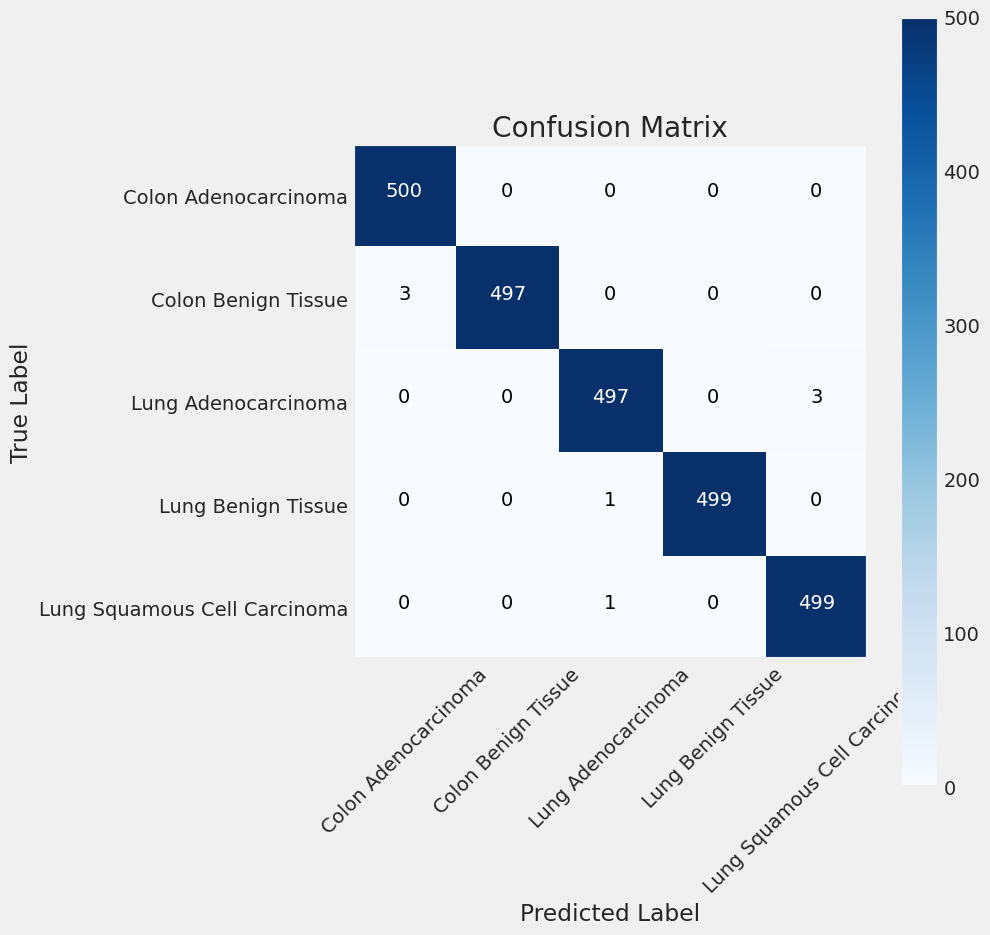

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.99      1.00      1.00       500
         Colon Benign Tissue       1.00      0.99      1.00       500
         Lung Adenocarcinoma       1.00      0.99      0.99       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.99      1.00      1.00       500

                    accuracy                           1.00      2500
                   macro avg       1.00      1.00      1.00      2500
                weighted avg       1.00      1.00      1.00      2500



In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_gen.classes, y_pred)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

def get_confusion_matrix_elements(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)
    return tp, tn, fp, fn

# Get confusion matrix elements
tp, tn, fp, fn = get_confusion_matrix_elements(cm)

# Print confusion matrix metrics for each class
for i, class_name in enumerate(classes):
    print(f"Class: {class_name}")
    print(f"  True Positives (TP): {tp[i]}")
    print(f"  True Negatives (TN): {tn[i]}")
    print(f"  False Positives (FP): {fp[i]}")
    print(f"  False Negatives (FN): {fn[i]}")
    print('-' * 20)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))


In [43]:
# Combine labels from train, test, and validation datasets
combined_labels = pd.concat([train_df['labels'], valid_df['labels'], test_df['labels']], ignore_index=True)

# Print total number of images in each class
class_counts = combined_labels.value_counts()
for label, count in class_counts.items():
    print(f"Total number of images in {label}: {count}")


Total number of images in Lung Adenocarcinoma: 5000
Total number of images in Lung Squamous Cell Carcinoma: 5000
Total number of images in Colon Adenocarcinoma: 5000
Total number of images in Lung Benign Tissue: 5000
Total number of images in Colon Benign Tissue: 5000
